# Results for Best XGBoost

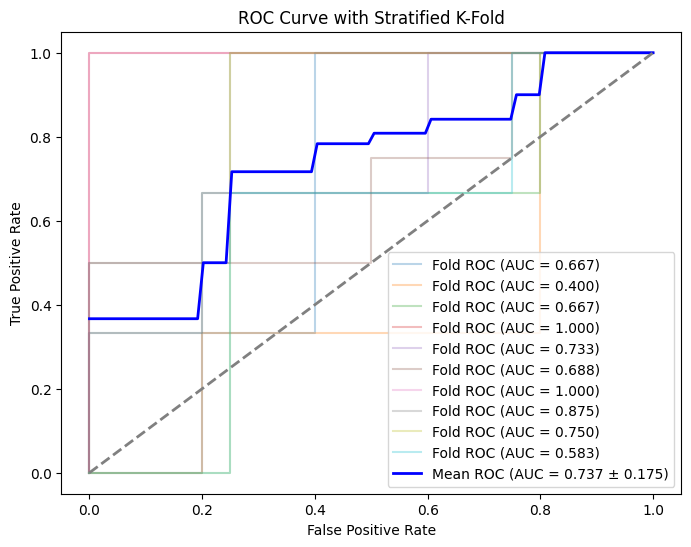

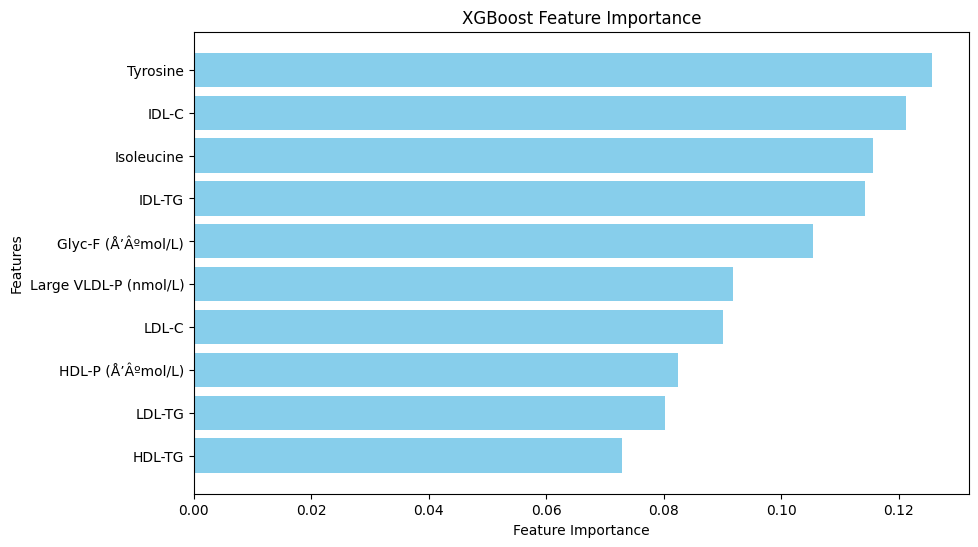

                 Feature  Importance
8               Tyrosine    0.125701
0                  IDL-C    0.121346
9             Isoleucine    0.115677
2                 IDL-TG    0.114351
7     Glyc-F (Å’Âºmol/L)    0.105505
5  Large VLDL-P (nmol/L)    0.091832
1                  LDL-C    0.090099
6      HDL-P (Å’Âºmol/L)    0.082485
3                 LDL-TG    0.080177
4                 HDL-TG    0.072827


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ------------------------ Data Loading & Preprocessing ------------------------ #
file_path = "covid_data_original.xlsx"
sheet_name = "merged_data (2)"
data = pd.read_excel(file_path, sheet_name=sheet_name)

def fill_dm(row):
    if pd.isnull(row['DM']):
        if row['DM_descript'] == "Yes":
            return 1.0
        elif row['DM_descript'] == "No":
            return 0.0
    return row['DM']

def fill_ds(row):
    if pd.isnull(row['dyslipidemia']):
        if row['dyslipidemia_descript'] == "Yes":
            return 1.0
        elif row['dyslipidemia_descript'] == "No":
            return 0.0
    return row['dyslipidemia']

data['DM'] = data.apply(fill_dm, axis=1)
data['dyslipidemia'] = data.apply(fill_ds, axis=1)

selected_columns = [
    'AGE', 'GENDER', 'Group', 'MED/statins', 'MED/DM', 'DM', 'dyslipidemia_descript',
    'VLDL-C', 'IDL-C', 'LDL-C', 'HDL-C', 'VLDL-TG', 'IDL-TG', 'LDL-TG', 'HDL-TG',
    'VLDL-P (nmol/L)', 'Large VLDL-P (nmol/L)', 'Medium VLDL-P (nmol/L)', 'Small VLDL-P (nmol/L)',
    'LDL-P (nmol/L)', 'Large LDL-P (nmol/L)', 'Medium LDL-P (nmol/L)', 'Small LDL-P (nmol/L)',
    'HDL-P (Å’Âºmol/L)', 'Large HDL-P (Å’Âºmol/L)', 'Medium HDL-P (Å’Âºmol/L)', 'Small HDL-P (Å’Âºmol/L)',
    'VLDL-Z (nm)', 'LDL-Z (nm)', 'HDL-Z (nm)', 'Glyc-B (Å’Âºmol/L)', 'Glyc-F (Å’Âºmol/L)',
    'Glyc-A (Å’Âºmol/L)', 'H/W Glyc-B', 'H/W Glyc-A', '3-Hydroxybutyrate', 'Acetate', 'Acetone',
    'Alanine', 'Creatinine', 'Creatine', 'Glucose', 'Glutamate', 'Glutamine', 'Glycerol', 'Glycine',
    'Histidine', 'Lactate', 'Threonine', 'Tyrosine', 'Valine', 'Isoleucine', 'Leucine', 'CRP', 'FERR',
    'psi'
]
data = data[selected_columns]

# Drop columns that contain NaN
data = data.dropna(axis=1)

# Use only Label Encoding for categorical variables
label_encoder = LabelEncoder()
data['Group'] = label_encoder.fit_transform(data['Group'])
data['GENDER'] = data['GENDER'].map({'M': 0, 'F': 1}).fillna(-1)
non_numeric_columns = data.select_dtypes(include=['object']).columns
for col in non_numeric_columns:
    data[col] = data[col].astype(str)
    data[col] = LabelEncoder().fit_transform(data[col])

# ------------------------ Feature Selection ------------------------ #
def select_features(X, y):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    selector = RFE(model, n_features_to_select=10, step=1)
    transformed = selector.fit_transform(X, y)
    selected_cols = X.columns[selector.support_]
    return pd.DataFrame(transformed, columns=selected_cols)

# ------------------------ Model Training & ROC AUC ------------------------ #
def train_and_evaluate_with_roc_auc(data):
    target = 'Group'
    X = data.drop(columns=[target])
    y = data[target]

    X = select_features(X, y)

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    model = XGBClassifier(subsample=0.8, n_estimators=300, max_depth=12,
                          learning_rate=0.01, gamma=0.1, colsample_bytree=0.8,
                          use_label_encoder=False, eval_metric='logloss', random_state=42)

    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    aucs = []
    plt.figure(figsize=(8, 6))

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        tprs.append(np.interp(mean_fpr, fpr, tpr))
        plt.plot(fpr, tpr, alpha=0.3, label=f'Fold ROC (AUC = {roc_auc:.3f})')

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Stratified K-Fold')
    plt.legend()
    plt.show()

    # Feature Importance
    feature_importances = model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('XGBoost Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

    print(importance_df)

train_and_evaluate_with_roc_auc(data)

# Results for Best MLP Model

In [ ]:
!pip install scikeras
!pip install bayesian-optimization
!pip install scikit-learn==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from bayes_opt import BayesianOptimization
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop

# Clear previous TensorFlow session
tf.keras.backend.clear_session()

# ------------------------ Data Loading & Preprocessing ------------------------ #
file_path = "covid_data_original.xlsx"
sheet_name = "merged_data (2)"
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Filling missing values
def fill_dm(row):
    if pd.isnull(row['DM']):
        return 1.0 if row['DM_descript'] == "Yes" else 0.0 if row['DM_descript'] == "No" else row['DM']
    return row['DM']

def fill_ds(row):
    if pd.isnull(row['dyslipidemia']):
        return 1.0 if row['dyslipidemia_descript'] == "Yes" else 0.0 if row['dyslipidemia_descript'] == "No" else row['dyslipidemia']
    return row['dyslipidemia']

data['DM'] = data.apply(fill_dm, axis=1)
data['dyslipidemia'] = data.apply(fill_ds, axis=1)

# Feature selection
selected_columns = [
    'AGE', 'GENDER', 'Group', 'MED/statins', 'MED/DM', 'DM', 'dyslipidemia_descript',
    'VLDL-C', 'IDL-C', 'LDL-C', 'HDL-C', 'VLDL-TG', 'IDL-TG', 'LDL-TG', 'HDL-TG',
    'VLDL-P (nmol/L)', 'Large VLDL-P (nmol/L)', 'Medium VLDL-P (nmol/L)', 'Small VLDL-P (nmol/L)',
    'LDL-P (nmol/L)', 'Large LDL-P (nmol/L)', 'Medium LDL-P (nmol/L)', 'Small LDL-P (nmol/L)',
    'HDL-P (Å’Âºmol/L)', 'Large HDL-P (Å’Âºmol/L)', 'Medium HDL-P (Å’Âºmol/L)', 'Small HDL-P (Å’Âºmol/L)',
    'VLDL-Z (nm)', 'LDL-Z (nm)', 'HDL-Z (nm)', 'Glyc-B (Å’Âºmol/L)', 'Glyc-F (Å’Âºmol/L)',
    'Glyc-A (Å’Âºmol/L)', 'H/W Glyc-B', 'H/W Glyc-A', '3-Hydroxybutyrate', 'Acetate', 'Acetone',
    'Alanine', 'Creatinine', 'Creatine', 'Glucose', 'Glutamate', 'Glutamine', 'Glycerol', 'Glycine',
    'Histidine', 'Lactate', 'Threonine', 'Tyrosine', 'Valine', 'Isoleucine', 'Leucine', 'CRP', 'FERR',
    'psi'
]
data = data[selected_columns]

# Drop columns that contain NaN
data = data.dropna(axis=1)

# Encode categorical variables
label_encoder = LabelEncoder()
data['Group'] = label_encoder.fit_transform(data['Group'])
data['GENDER'] = data['GENDER'].map({'M': 0, 'F': 1}).fillna(-1)
non_numeric_columns = data.select_dtypes(include=['object']).columns
for col in non_numeric_columns:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# Feature selection with RFE
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
selector = RFE(xgb_model, n_features_to_select=10, step=1)
X = selector.fit_transform(data.drop(columns=['Group']), data['Group'])
y = data['Group']

# Scaling with RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(X)

# ------------------------ Define NN Model ------------------------ #
def create_nn(input_dim, optimizer, neurons, dropout_rate, activation, learning_rate):
    """Builds a Keras model with given hyperparameters"""
    activation_functions = ['relu', 'tanh', 'sigmoid']
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate)
    }
    optimizer = optimizers[optimizer]  # Get optimizer with learning rate

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(int(neurons[0]), activation=activation, kernel_regularizer=l2(0.001)),
        Dropout(dropout_rate),
        Dense(int(neurons[1]), activation=activation, kernel_regularizer=l2(0.001)),
        Dropout(dropout_rate),
        Dense(int(neurons[2]), activation=activation, kernel_regularizer=l2(0.001)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# ------------------------ Bayesian Optimization Function ------------------------ #
def evaluate_nn(optimizer, neurons1, neurons2, neurons3, dropout_rate, activation, batch_size, epochs, learning_rate):
    tf.keras.backend.clear_session()

    neurons = [neurons1, neurons2, neurons3]
    optimizer_name = ['adam', 'nadam', 'sgd', 'rmsprop'][int(optimizer)]
    activation_name = ['relu', 'tanh', 'sigmoid'][int(activation)]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_acc_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[test_idx]
        y_train, y_val = y[train_idx], y[test_idx]

        model = create_nn(X_train.shape[1], optimizer_name, neurons, dropout_rate, activation_name, learning_rate)

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=int(epochs), batch_size=int(batch_size), verbose=0)

        val_acc_scores.append(max(history.history['val_accuracy']))

    return np.mean(val_acc_scores)  # Return average validation accuracy across folds

# ------------------------ Define Hyperparameter Search Space ------------------------ #
pbounds = {
    'optimizer': (0, 3),  # ['adam', 'nadam', 'sgd', 'rmsprop']
    'neurons1': (32, 256),
    'neurons2': (16, 128),
    'neurons3': (8, 64),
    'dropout_rate': (0.1, 0.4),
    'activation': (0, 2),  # ['relu', 'tanh', 'sigmoid']
    'batch_size': (4, 32),
    'epochs': (50, 150),
    'learning_rate': (0.0001, 0.01)
}

# ------------------------ Run Bayesian Optimization ------------------------ #
optimizer = BayesianOptimization(
    f=evaluate_nn,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

print("Starting Bayesian Optimization...")
optimizer.maximize(init_points=5, n_iter=15)

# ------------------------ Best Results ------------------------ #
best_params = optimizer.max['params']
best_params['optimizer'] = ['adam', 'nadam', 'sgd', 'rmsprop'][int(best_params['optimizer'])]
best_params['activation'] = ['relu', 'tanh', 'sigmoid'][int(best_params['activation'])]

print("\nBest Hyperparameters:")
print(best_params)

Starting Bayesian Optimization...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | learni... | neurons1  | neurons2  | neurons3  | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7583    | 0.7491    | 30.62     | 0.3196    | 109.9     | 0.001645  | 66.94     | 22.51     | 56.51     | 1.803     |
| 2         | 0.745     | 1.416     | 4.576     | 0.391     | 133.2     | 0.002202  | 72.73     | 36.54     | 25.04     | 1.574     |
| 3         | 0.77      | 0.8639    | 12.15     | 0.2836    | 63.95     | 0.002992  | 114.1     | 67.08     | 51.97     | 0.599     |
| 4         | 0.7317    | 1.028     | 20.59     | 0.1139    | 110.8     | 0.001788  | 46.57     | 122.3     | 62.08     | 2.425     |
| 5         | 0.7958    | 0.6092    | 6.735     | 0.3053    | 94.02     | 0.001308  | 142.9     | 19.85     | 58.92     | 0.7763    |
| 6         | 0.7817    | 0.

ExactExplainer explainer: 17it [01:30,  5.63s/it]
ExactExplainer explainer: 17it [01:24,  5.63s/it]
ExactExplainer explainer: 17it [01:12,  5.21s/it]
ExactExplainer explainer: 16it [01:10,  5.39s/it]
ExactExplainer explainer: 16it [01:10,  5.05s/it]


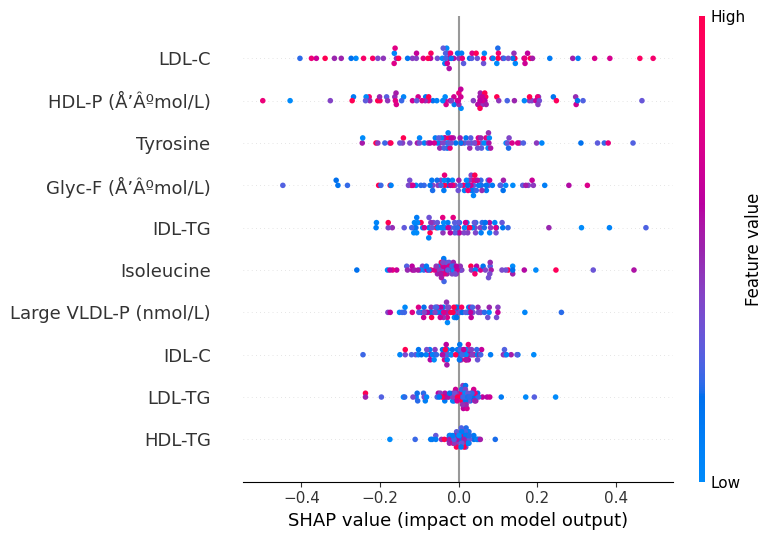

Mean ROC AUC across folds: 0.7127


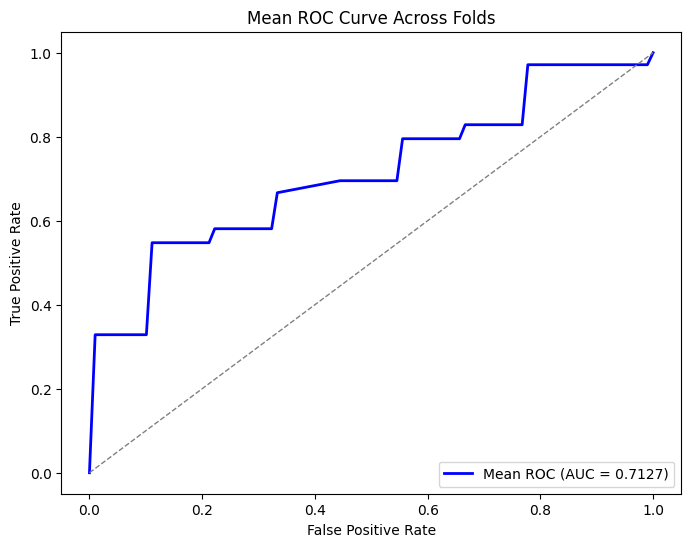

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
import tensorflow as tf

# Clear previous TensorFlow session
tf.keras.backend.clear_session()

# ------------------------ Data Loading & Preprocessing ------------------------ #
file_path = "covid_data_original.xlsx"
sheet_name = "merged_data (2)"
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Filling missing values
def fill_dm(row):
    if pd.isnull(row['DM']):
        return 1.0 if row['DM_descript'] == "Yes" else 0.0 if row['DM_descript'] == "No" else row['DM']
    return row['DM']

def fill_ds(row):
    if pd.isnull(row['dyslipidemia']):
        return 1.0 if row['dyslipidemia_descript'] == "Yes" else 0.0 if row['dyslipidemia_descript'] == "No" else row['dyslipidemia']
    return row['dyslipidemia']

data['DM'] = data.apply(fill_dm, axis=1)
data['dyslipidemia'] = data.apply(fill_ds, axis=1)

# Feature selection: select only the needed columns
selected_columns = [
    'AGE', 'GENDER', 'Group', 'MED/statins', 'MED/DM', 'DM', 'dyslipidemia_descript',
    'VLDL-C', 'IDL-C', 'LDL-C', 'HDL-C', 'VLDL-TG', 'IDL-TG', 'LDL-TG', 'HDL-TG',
    'VLDL-P (nmol/L)', 'Large VLDL-P (nmol/L)', 'Medium VLDL-P (nmol/L)', 'Small VLDL-P (nmol/L)',
    'LDL-P (nmol/L)', 'Large LDL-P (nmol/L)', 'Medium LDL-P (nmol/L)', 'Small LDL-P (nmol/L)',
    'HDL-P (Å’Âºmol/L)', 'Large HDL-P (Å’Âºmol/L)', 'Medium HDL-P (Å’Âºmol/L)', 'Small HDL-P (Å’Âºmol/L)',
    'VLDL-Z (nm)', 'LDL-Z (nm)', 'HDL-Z (nm)', 'Glyc-B (Å’Âºmol/L)', 'Glyc-F (Å’Âºmol/L)',
    'Glyc-A (Å’Âºmol/L)', 'H/W Glyc-B', 'H/W Glyc-A', '3-Hydroxybutyrate', 'Acetate', 'Acetone',
    'Alanine', 'Creatinine', 'Creatine', 'Glucose', 'Glutamate', 'Glutamine', 'Glycerol', 'Glycine',
    'Histidine', 'Lactate', 'Threonine', 'Tyrosine', 'Valine', 'Isoleucine', 'Leucine', 'CRP', 'FERR',
    'psi'
]
data = data[selected_columns]

# Drop columns that contain NaN values
data = data.dropna(axis=1)

# Encode categorical variables
label_encoder = LabelEncoder()
data['Group'] = label_encoder.fit_transform(data['Group'])
data['GENDER'] = data['GENDER'].map({'M': 0, 'F': 1}).fillna(-1)
non_numeric_columns = data.select_dtypes(include=['object']).columns
for col in non_numeric_columns:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# ------------------------ Feature Selection Function ------------------------ #
def select_features(X, y):
    from xgboost import XGBClassifier
    from sklearn.feature_selection import RFE

    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    selector = RFE(model, n_features_to_select=10, step=1)
    transformed = selector.fit_transform(X, y)
    selected_cols = X.columns[selector.support_]
    return pd.DataFrame(transformed, columns=selected_cols)

# ------------------------ MLP Model Definition ------------------------ #
def create_nn(input_dim, activation='relu', optimizer='adam', dropout_rate=0.16,
              neurons1=165, neurons2=21, neurons3=42, learning_rate=0.01):
    # Instantiate optimizer with the provided learning rate
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = optimizer

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(int(neurons1), activation=activation, kernel_regularizer=l2(0.001)),
        Dropout(dropout_rate),
        Dense(int(neurons2), activation=activation, kernel_regularizer=l2(0.001)),
        Dropout(dropout_rate),
        Dense(int(neurons3), activation=activation, kernel_regularizer=l2(0.001)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ------------------------ Model Training, Evaluation, ROC AUC & SHAP Analysis ------------------------ #
def train_and_evaluate_with_shap(data):
    target = 'Group'
    X = data.drop(columns=[target])
    y = data[target]

    # Select top features
    X = select_features(X, y)

    # Standardize features
    scaler_std = StandardScaler()
    X = pd.DataFrame(scaler_std.fit_transform(X), columns=X.columns)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use the best hyperparameters from your tuning
    best_params = {
        'activation': 'relu',
        'batch_size': int(round(29.57113563028534)),
        'dropout_rate': 0.283138040320791,
        'epochs': int(round(79.81378298911514)),
        'learning_rate': 0.008325420344431183,
        'neurons1': int(round(180.34652761177082)),
        'neurons2': int(round(104.24833328638891)),
        'neurons3': int(round(34.8891722704045)),
        'optimizer': 'nadam'
    }
    model = KerasClassifier(
        model=create_nn,
        model__input_dim=X.shape[1],
        model__activation=best_params['activation'],
        model__optimizer=best_params['optimizer'],
        model__dropout_rate=best_params['dropout_rate'],
        model__neurons1=best_params['neurons1'],
        model__neurons2=best_params['neurons2'],
        model__neurons3=best_params['neurons3'],
        model__learning_rate=best_params['learning_rate'],
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0
    )

    all_shap_values = []
    auc_scores = []
    # For averaging ROC curve across folds
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)

        # Predict probabilities for ROC AUC
        y_pred_prob = model.predict_proba(X_test)
        # For binary classification, ensure predictions are the probabilities for the positive class
        if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
            y_pred_prob = y_pred_prob[:, 1]

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        fold_auc = auc(mean_fpr, interp_tpr)
        auc_scores.append(fold_auc)

        # SHAP analysis on this fold
        explainer = shap.Explainer(model.predict, X_train)
        shap_values = explainer(X_test)
        all_shap_values.append(shap_values.values)

    # Concatenate SHAP values across folds and generate summary plot
    combined_shap_values = np.concatenate(all_shap_values, axis=0)
    shap.summary_plot(combined_shap_values, X, feature_names=X.columns)

    # Compute average ROC curve and AUC score
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    print(f"Mean ROC AUC across folds: {mean_auc:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.4f})', lw=2)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve Across Folds')
    plt.legend(loc="lower right")
    plt.show()

train_and_evaluate_with_shap(data)